### Manage imports


In [1]:
import scipy
import os
import mne
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from einops import reduce
import seaborn as sns
from scipy import io

from Electrodes import Electrodes

plt.rcParams.update({'figure.max_open_warning': 0})

### Read data from local

In [2]:
# Constants used to define data paths
ROOT_DIR = './'
RAW_DIR = 'data/matlabPREPROCESSED'
PROCESSED_DIR = 'data/graphProcessedData'

In [3]:
raw_file_names = os.listdir(RAW_DIR)
raw_file_names.sort()
all_subjects = [scipy.io.loadmat(f'{RAW_DIR}/{name}') for name in raw_file_names]

In [4]:
all_data = [subject['data'] for subject in all_subjects]
all_labels = [subject['labels'] for subject in all_subjects]
labels = np.stack(all_labels)
all_labels = reduce(labels,'s v c -> (s v) c','mean')
data = np.stack(all_data)
all_data = reduce(data,'s v c d -> (s v) c d','mean')

## Plot label distribution for each subject

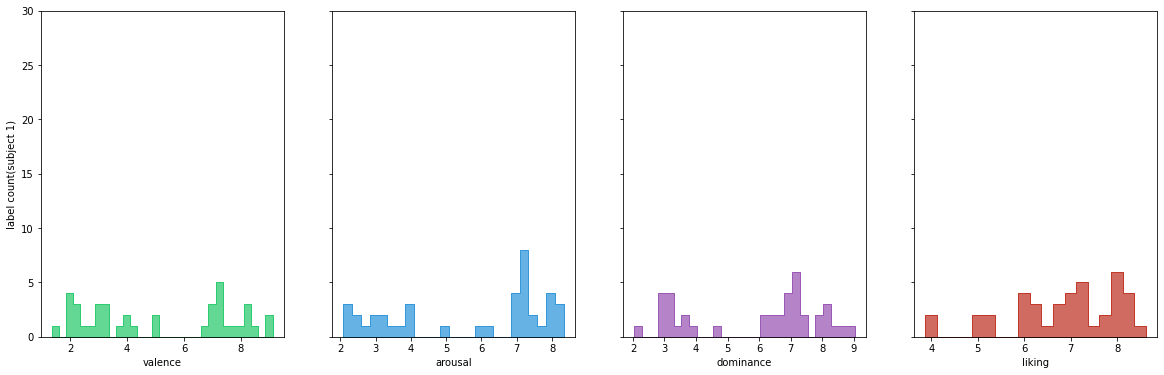

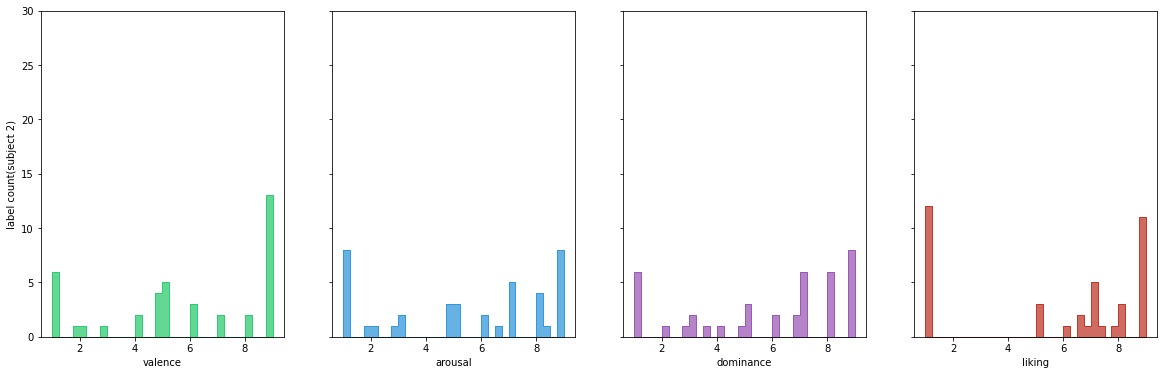

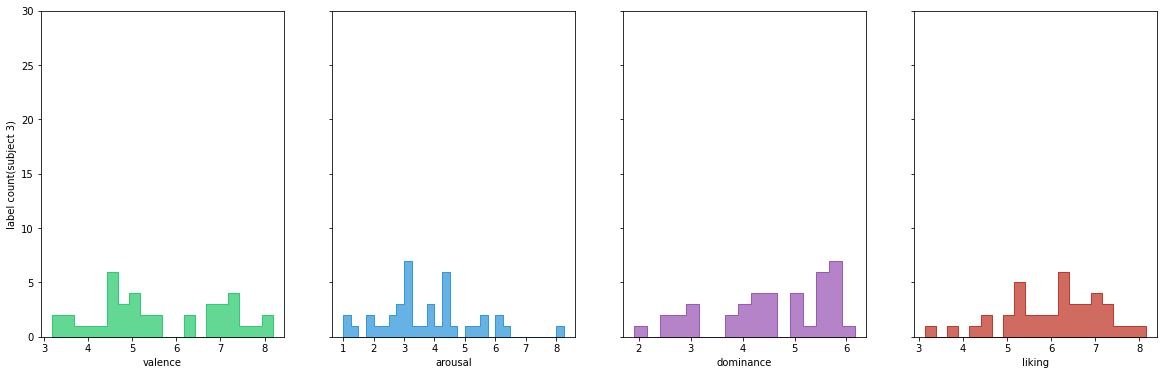

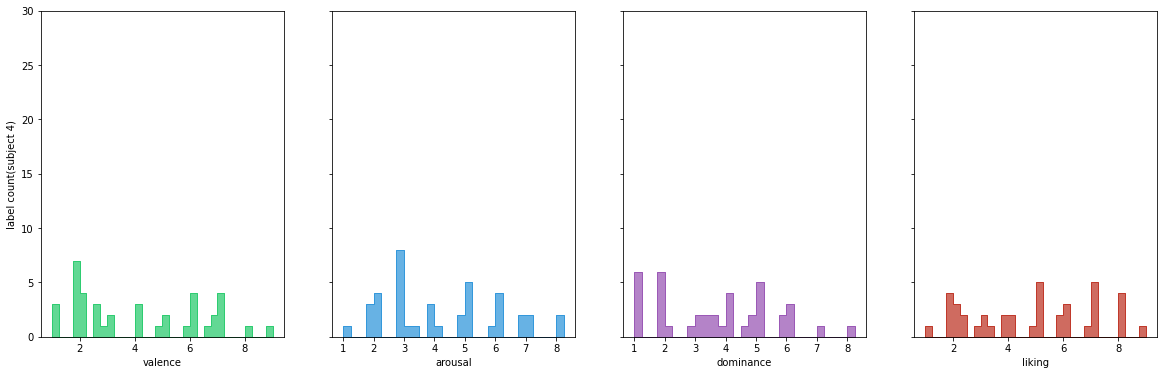

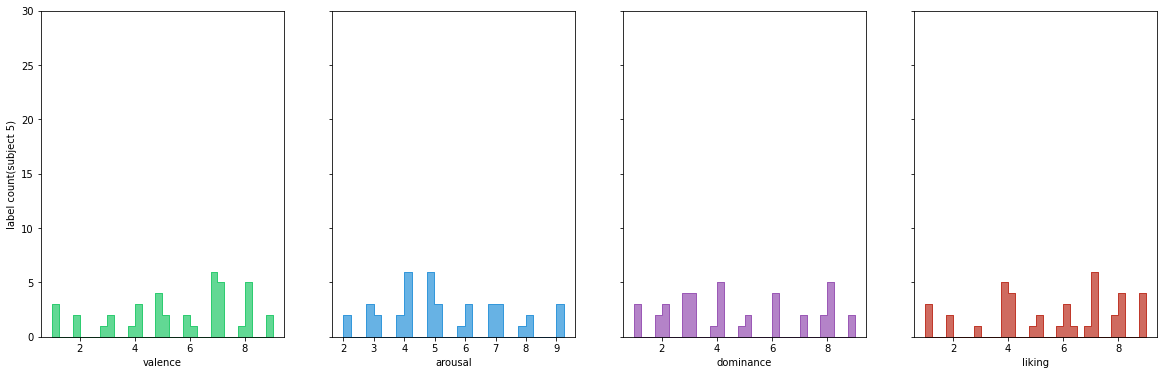

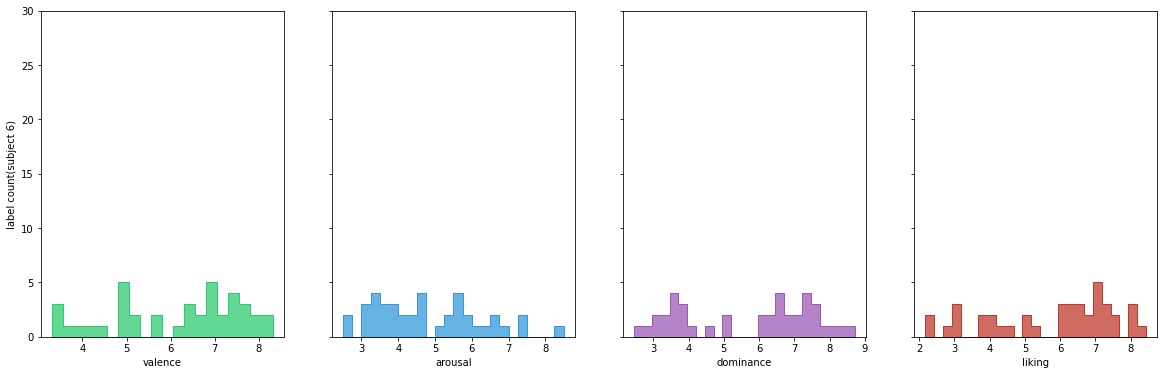

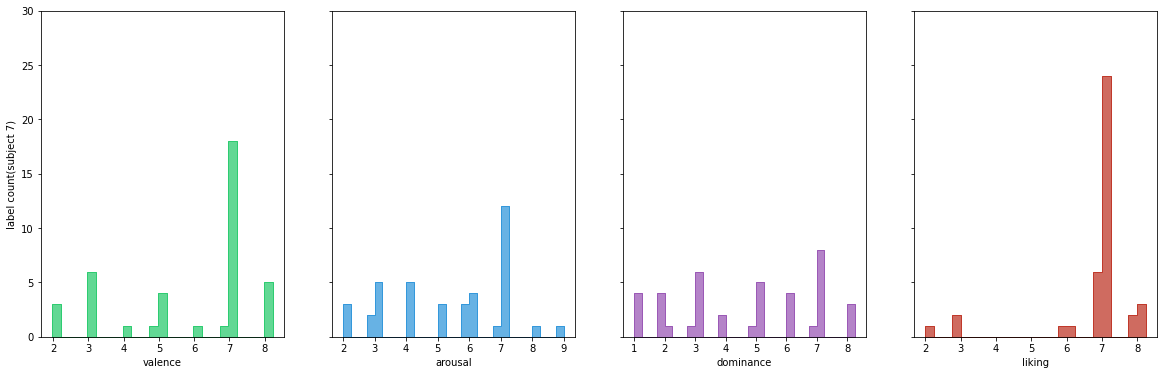

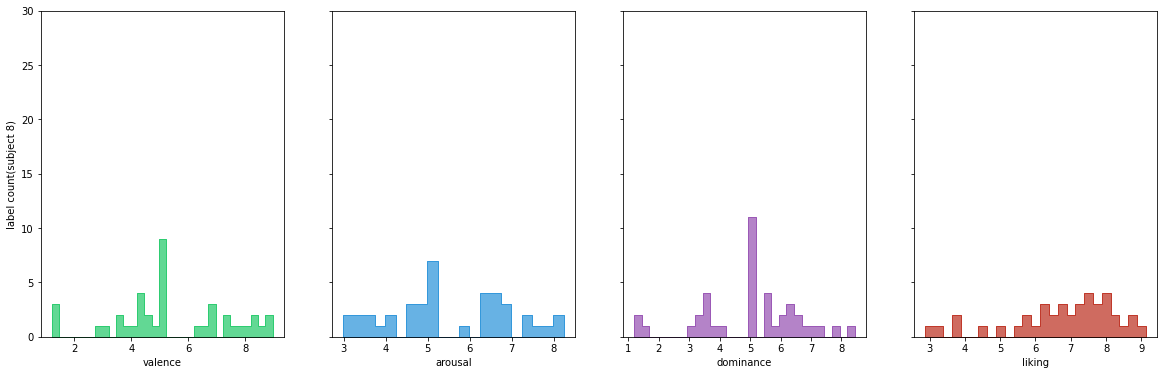

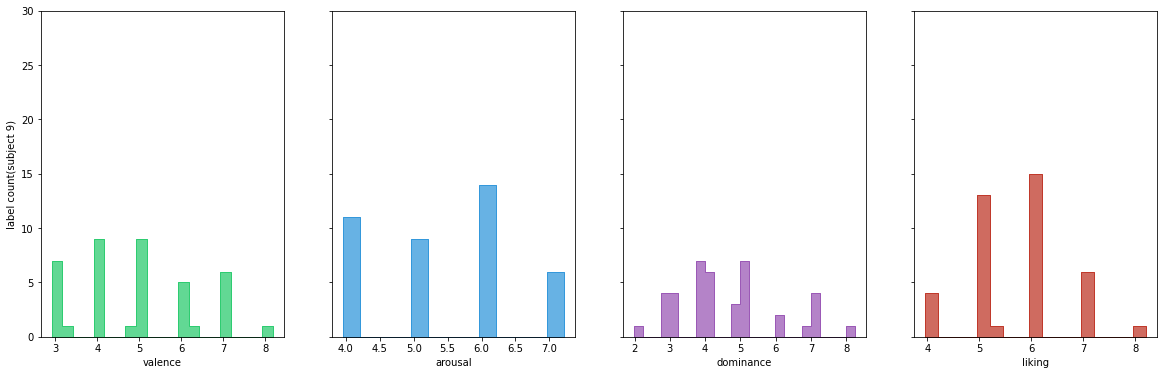

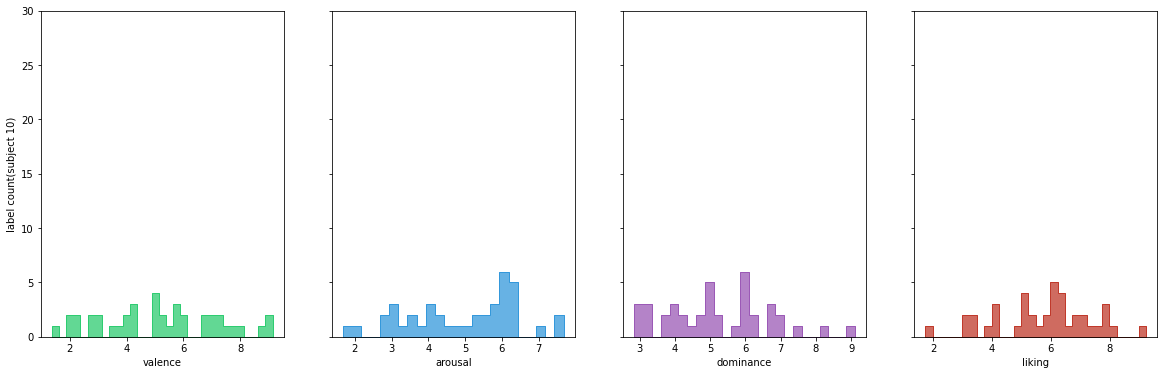

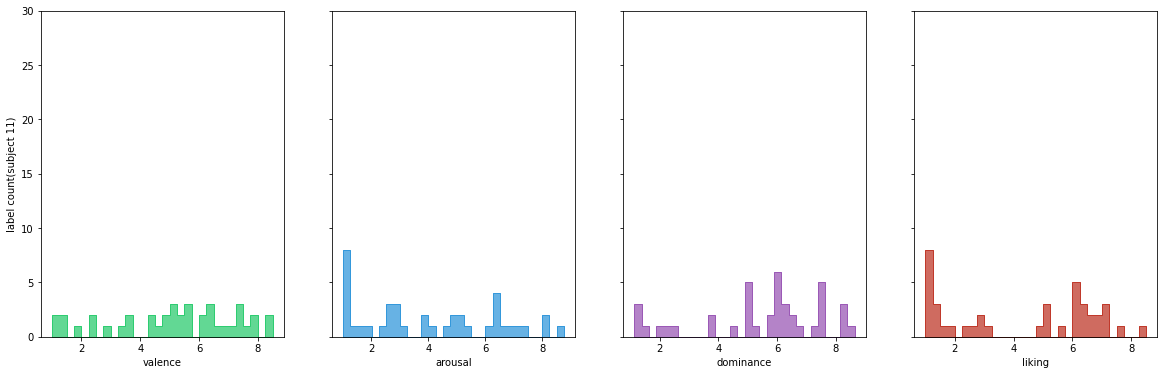

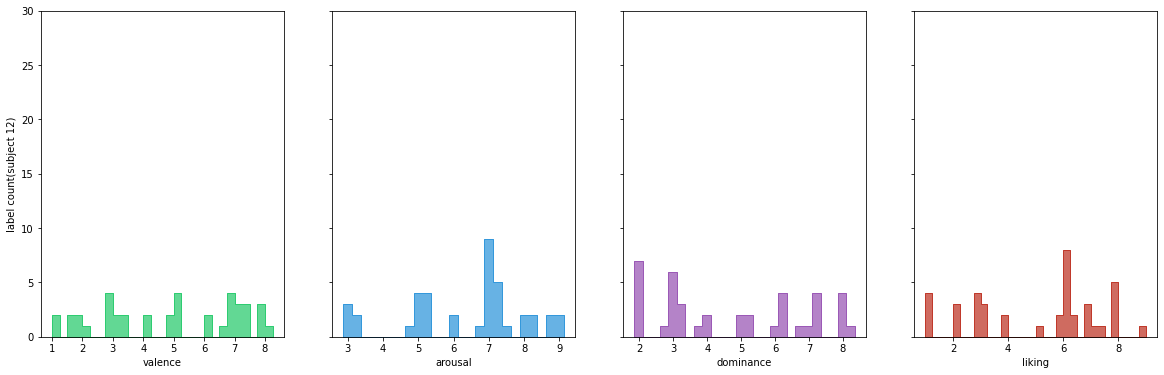

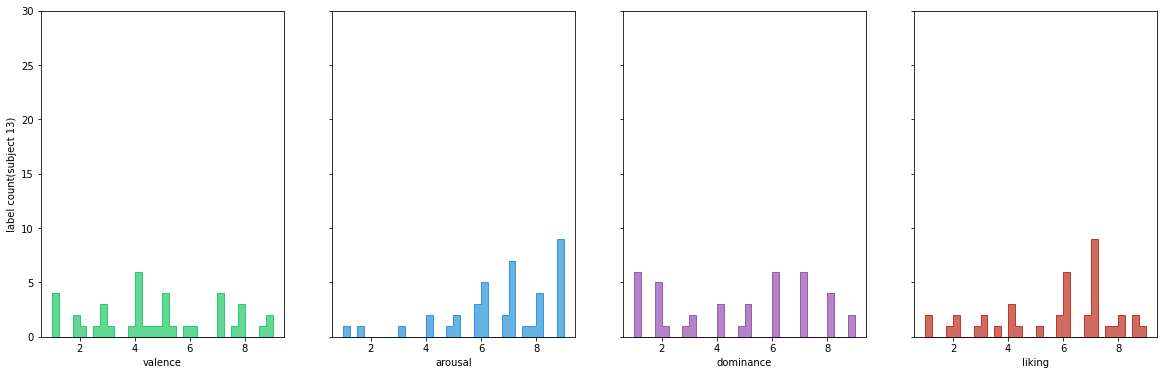

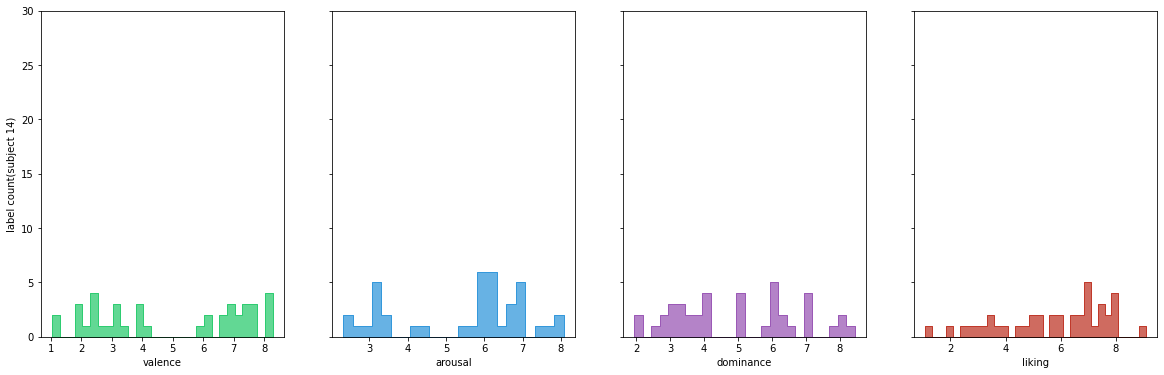

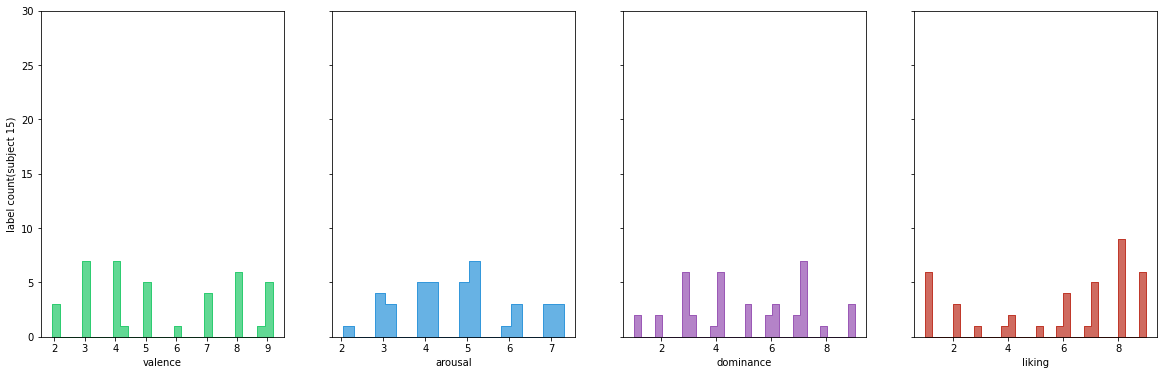

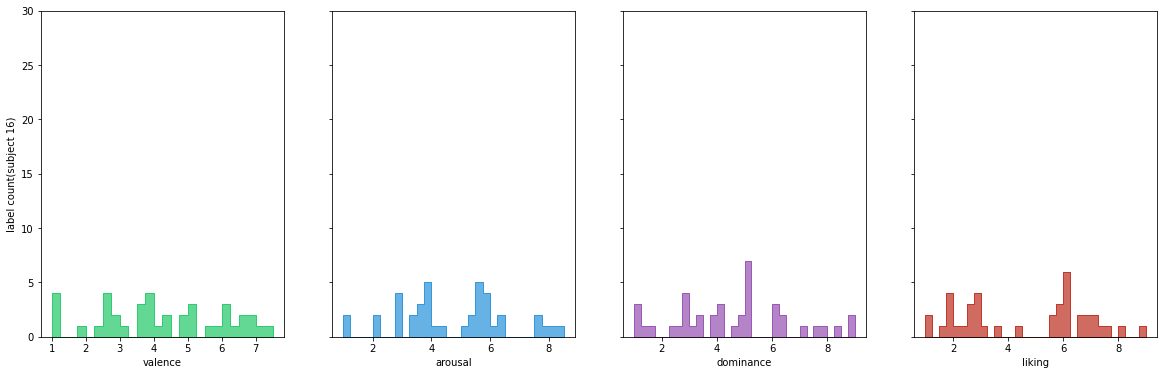

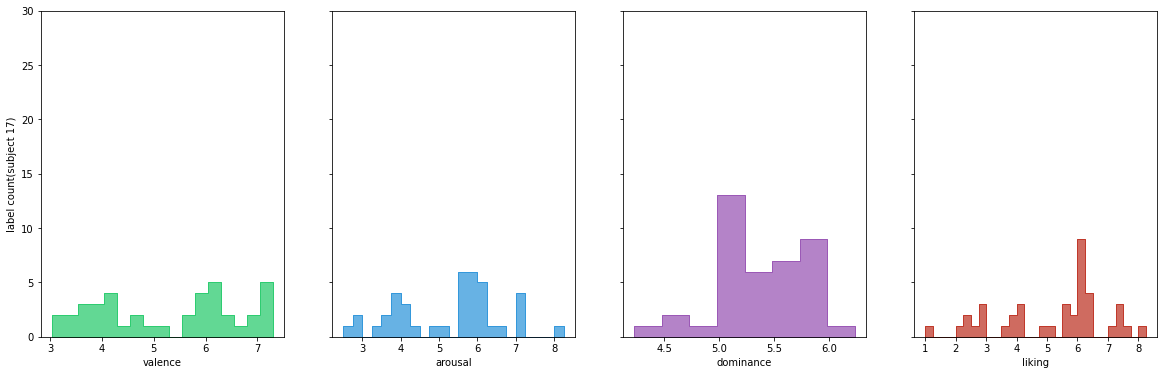

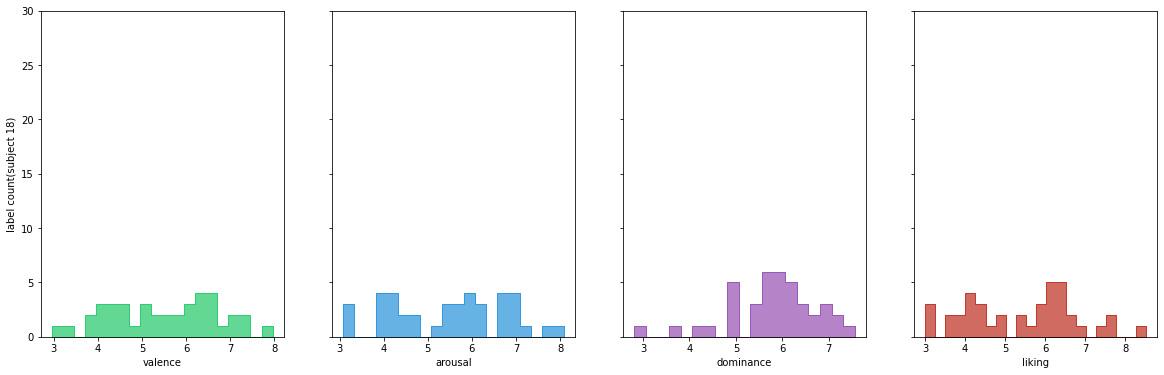

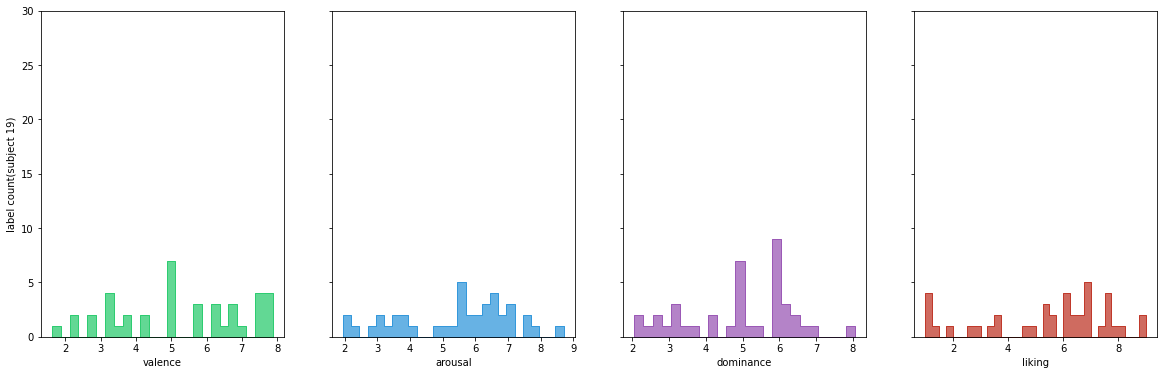

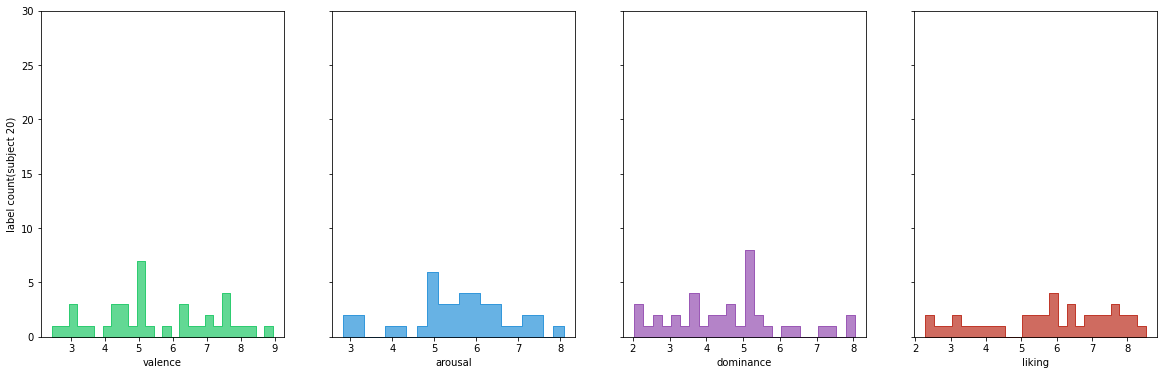

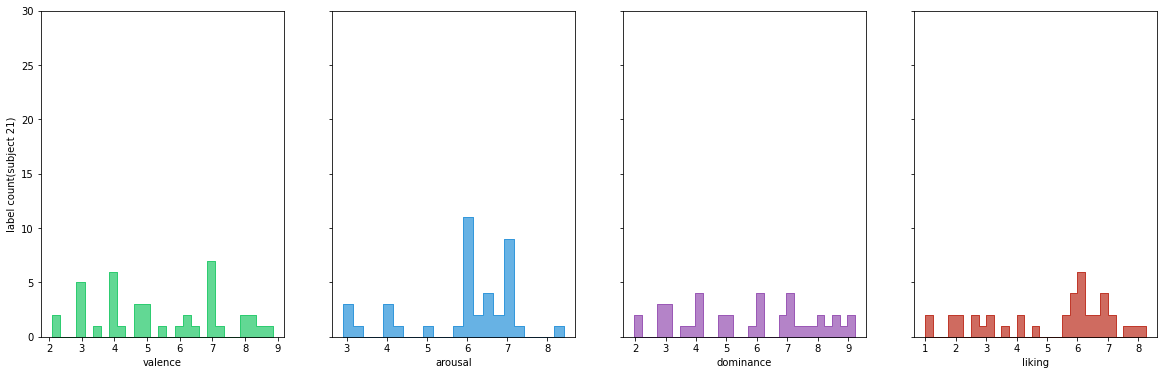

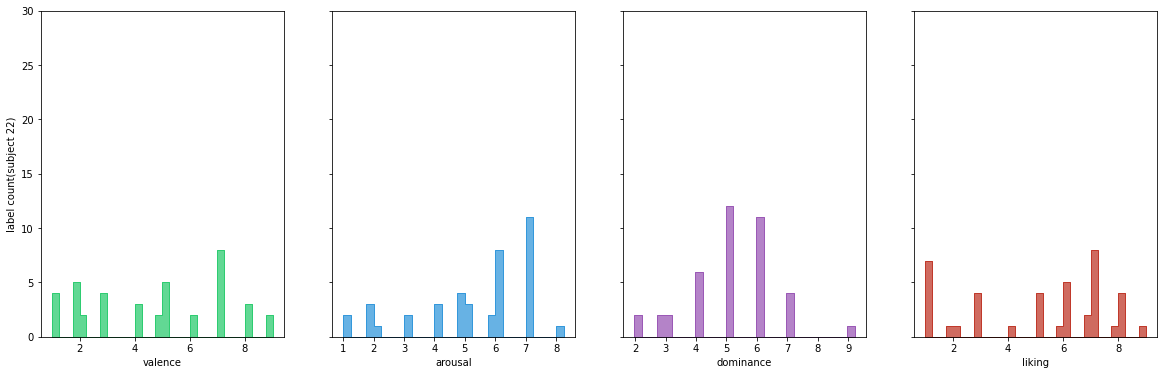

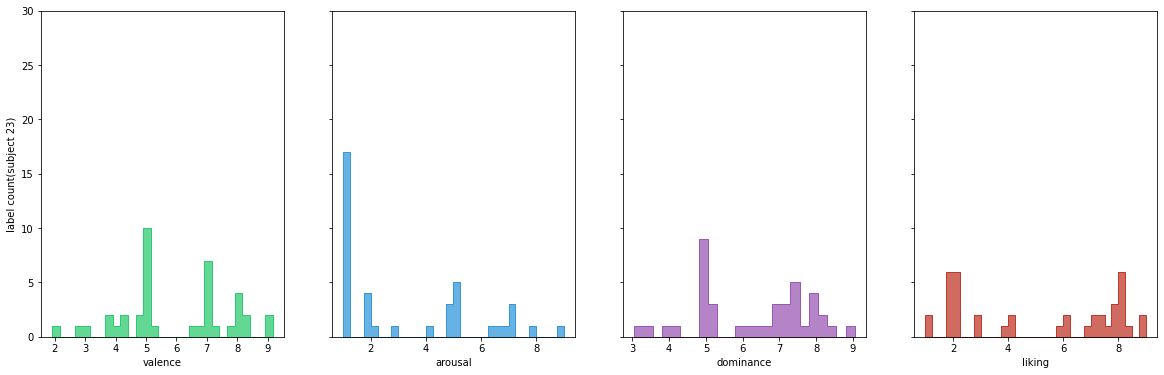

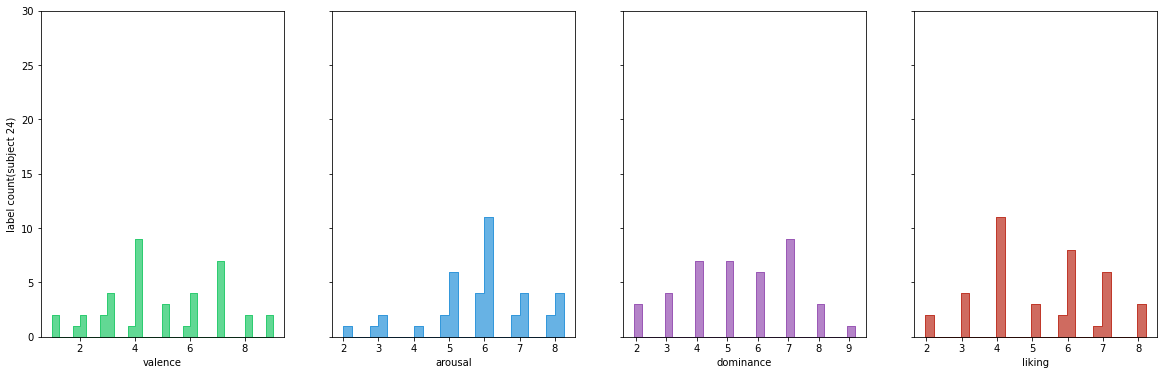

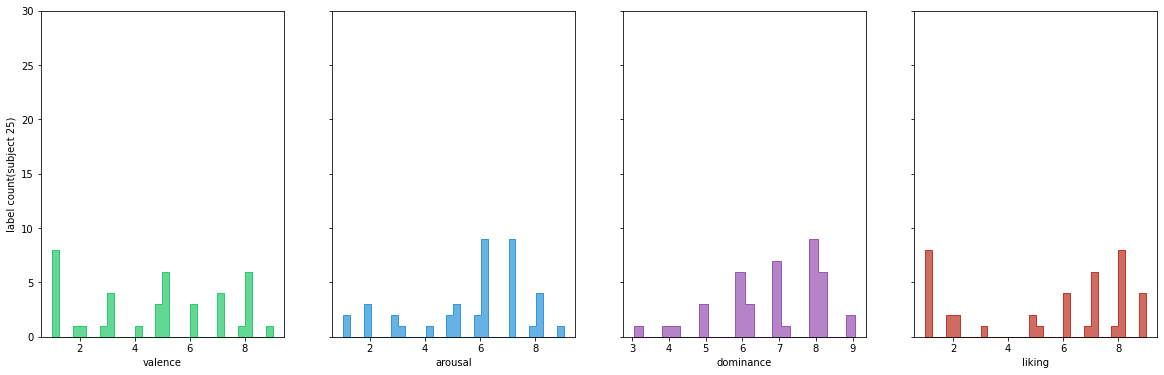

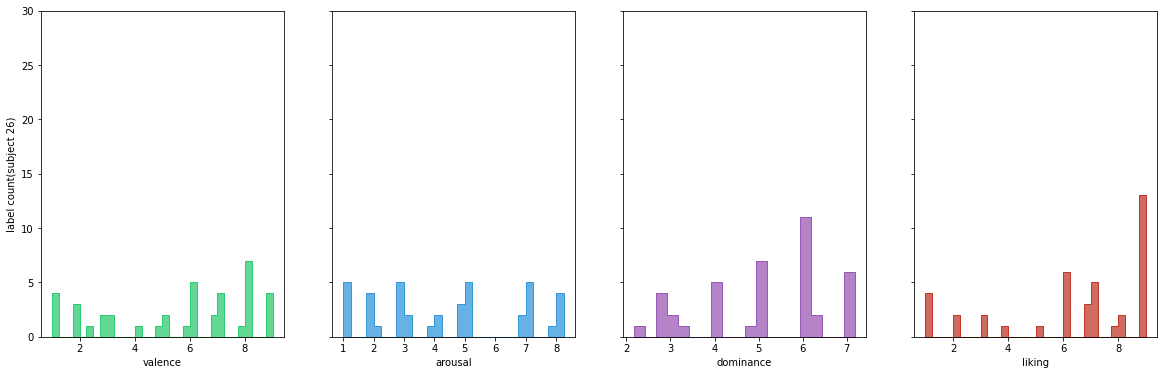

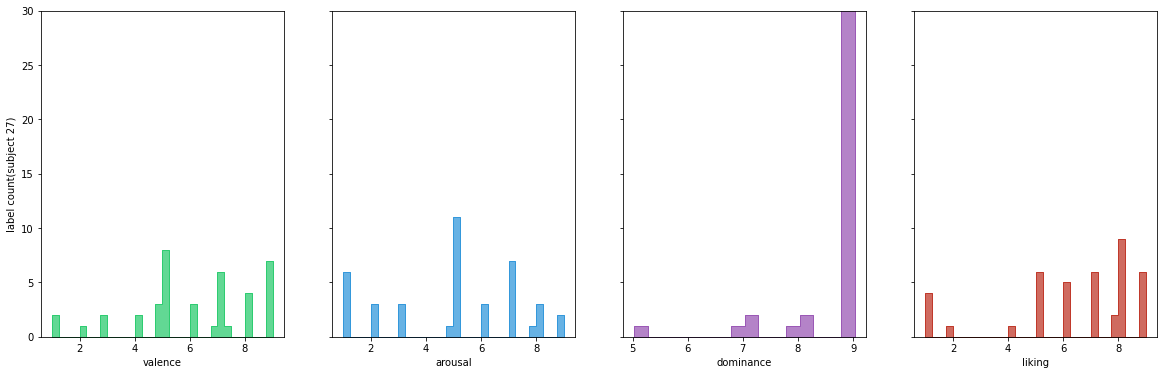

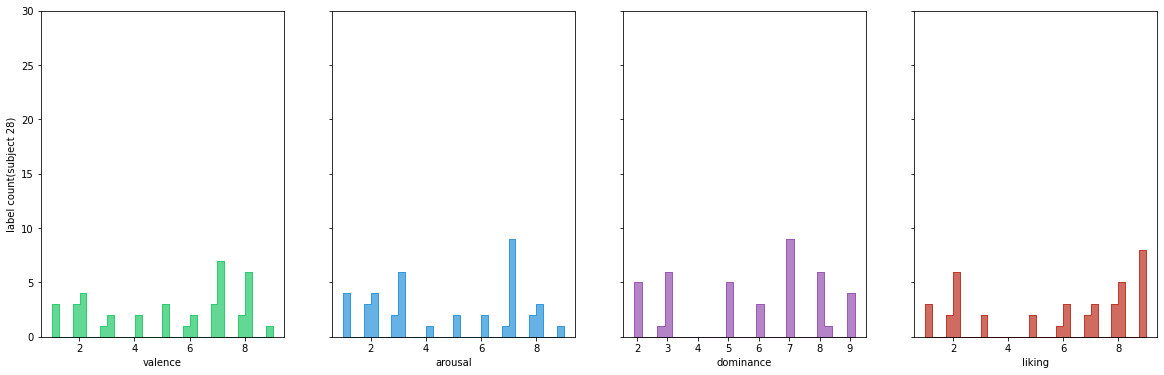

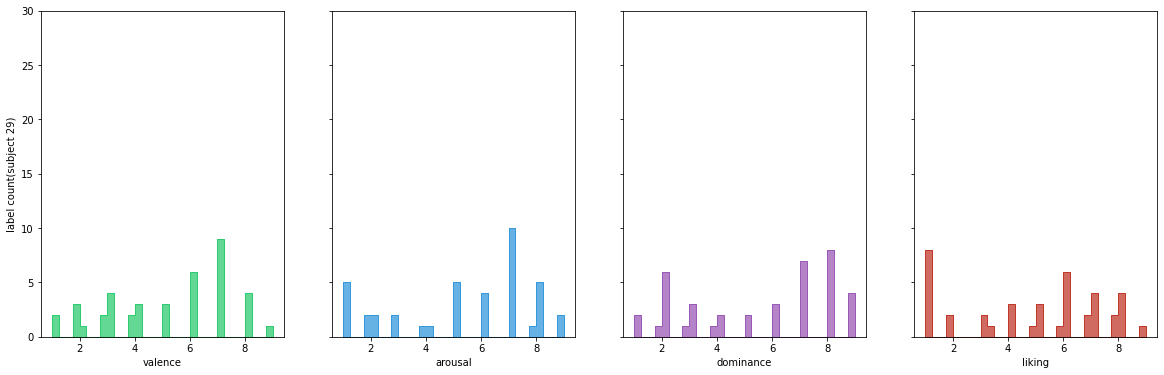

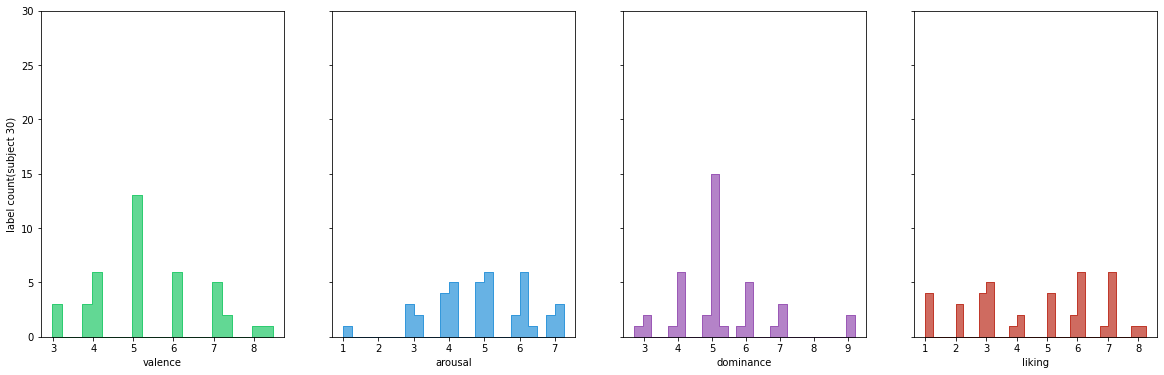

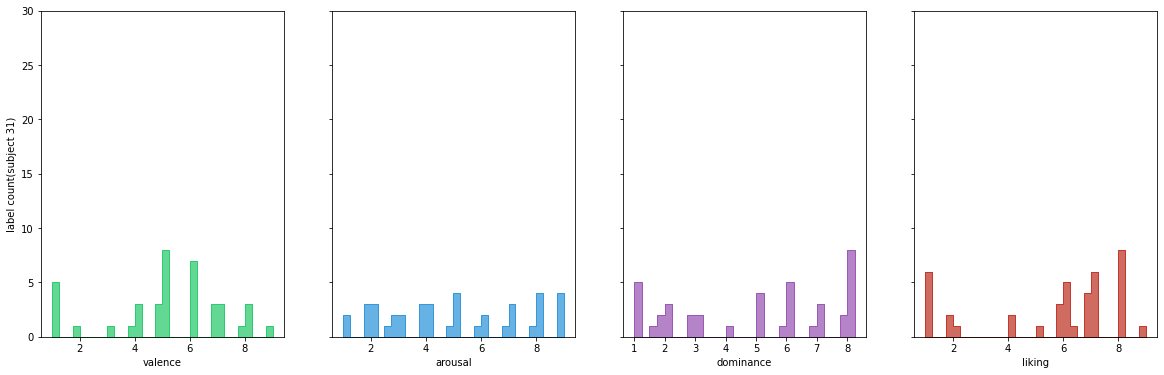

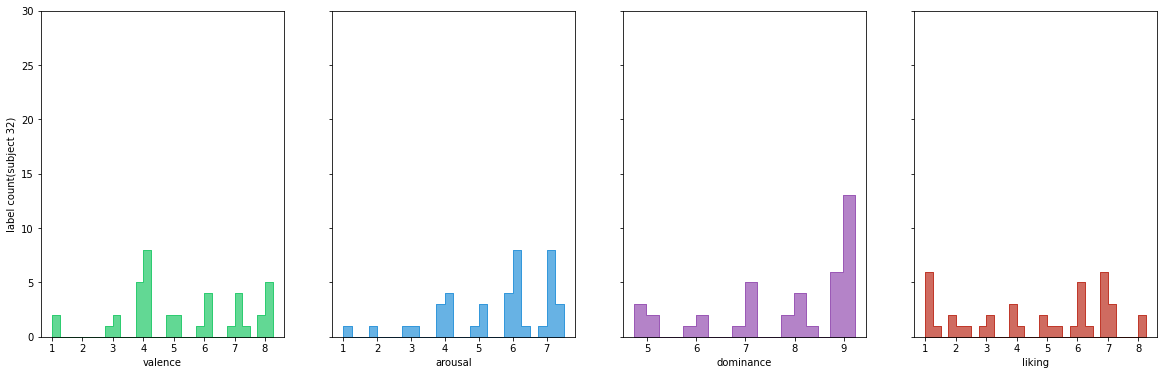

In [5]:
colors=['#2ecc71','#3498db','#9b59b6','#c0392b']
targets = ['valence','arousal','dominance','liking']
for subject_id,subject in enumerate(labels):
    fig, ax =plt.subplots(ncols=4, sharey=True, figsize=(20, 6))
    for i,a in enumerate(subject.T):
        sns.histplot(a, kde=False, element="step", binwidth=0.25,color=colors[i],ax=ax[i]).set(xlabel=f'{targets[i]}', ylabel=f'label count(subject {subject_id+1})',ylim=(0, 30))

## Plot label distribution for all subjects

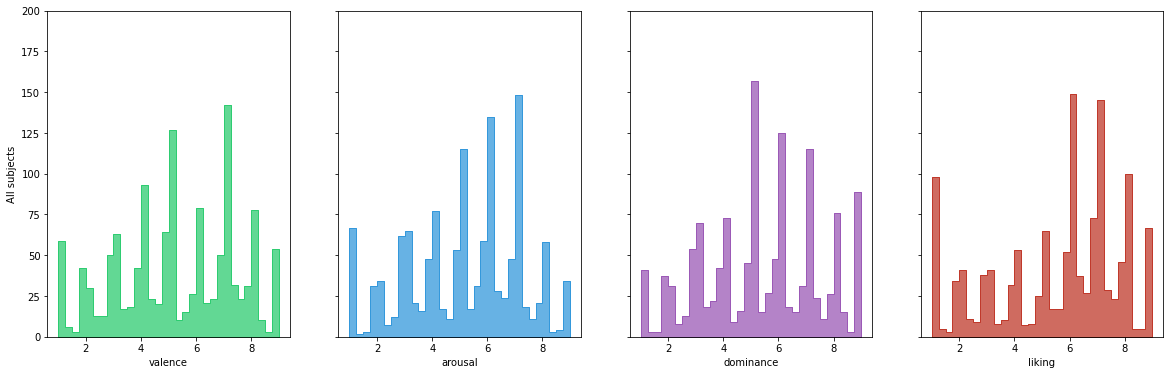

In [6]:
fig, ax =plt.subplots(ncols=4, sharey=True, figsize=(20, 6))
for i,a in enumerate(all_labels.T):
    sns.histplot(a, kde=False, element="step", binwidth=0.25,color=colors[i],ax=ax[i]).set(xlabel=f'{targets[i]}', ylabel=f'All subjects',ylim=(0, 200))

## Visualize eeg data for a certain trial

In [7]:
# Index video and participant to show (starts at 0)
PARTICIPANT_ID = 0
VIDEO_ID = 8

valence, arousal, dominance, liking = labels[PARTICIPANT_ID][VIDEO_ID]
print(f'Labels: \n Valence: {valence}   Arousal: {arousal} \n Dominance: {dominance}   Liking: {liking}')

Labels: 
 Valence: 4.04   Arousal: 3.29 
 Dominance: 3.62   Liking: 5.99


### Make data chunks

Each chunk is defined as the mean for every channel within a certain time window

**2 cases:**
- 1st: time window is the whole trial (63 seconds @ 128Hz -> 8064 data points)
- 2nd: time window is 5.25 seconds (5.25 seconds @ 128Hz -> 672 data points for each chunk)

In [8]:
electrodes = Electrodes()
# Get 12 chunks from the 8064 elements and perform the mean for each
eeg_mean = reduce(data[PARTICIPANT_ID][VIDEO_ID][:32],'b (c n) -> b n c','mean',n=12)
eeg_mean = eeg_mean.mean(axis=-1)
# Each chunk is 5.25 seconds -> 672 Hz @ 128 Hz sampling 
chunks = eeg_mean.T
# Show 1 chunk
all_eeg_mean = data[PARTICIPANT_ID][VIDEO_ID][:32].mean(axis=-1)

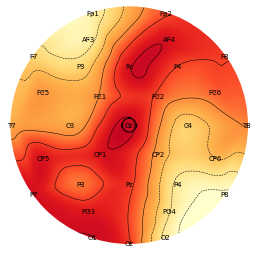

In [9]:
# Show video as 1 chunk
fig, ax = plt.subplots()
im,_ = mne.viz.topomap.plot_topomap(all_eeg_mean,electrodes.positions_2d,names=electrodes.channel_names,show_names=True,axes=ax,cmap='YlOrRd',show=False)

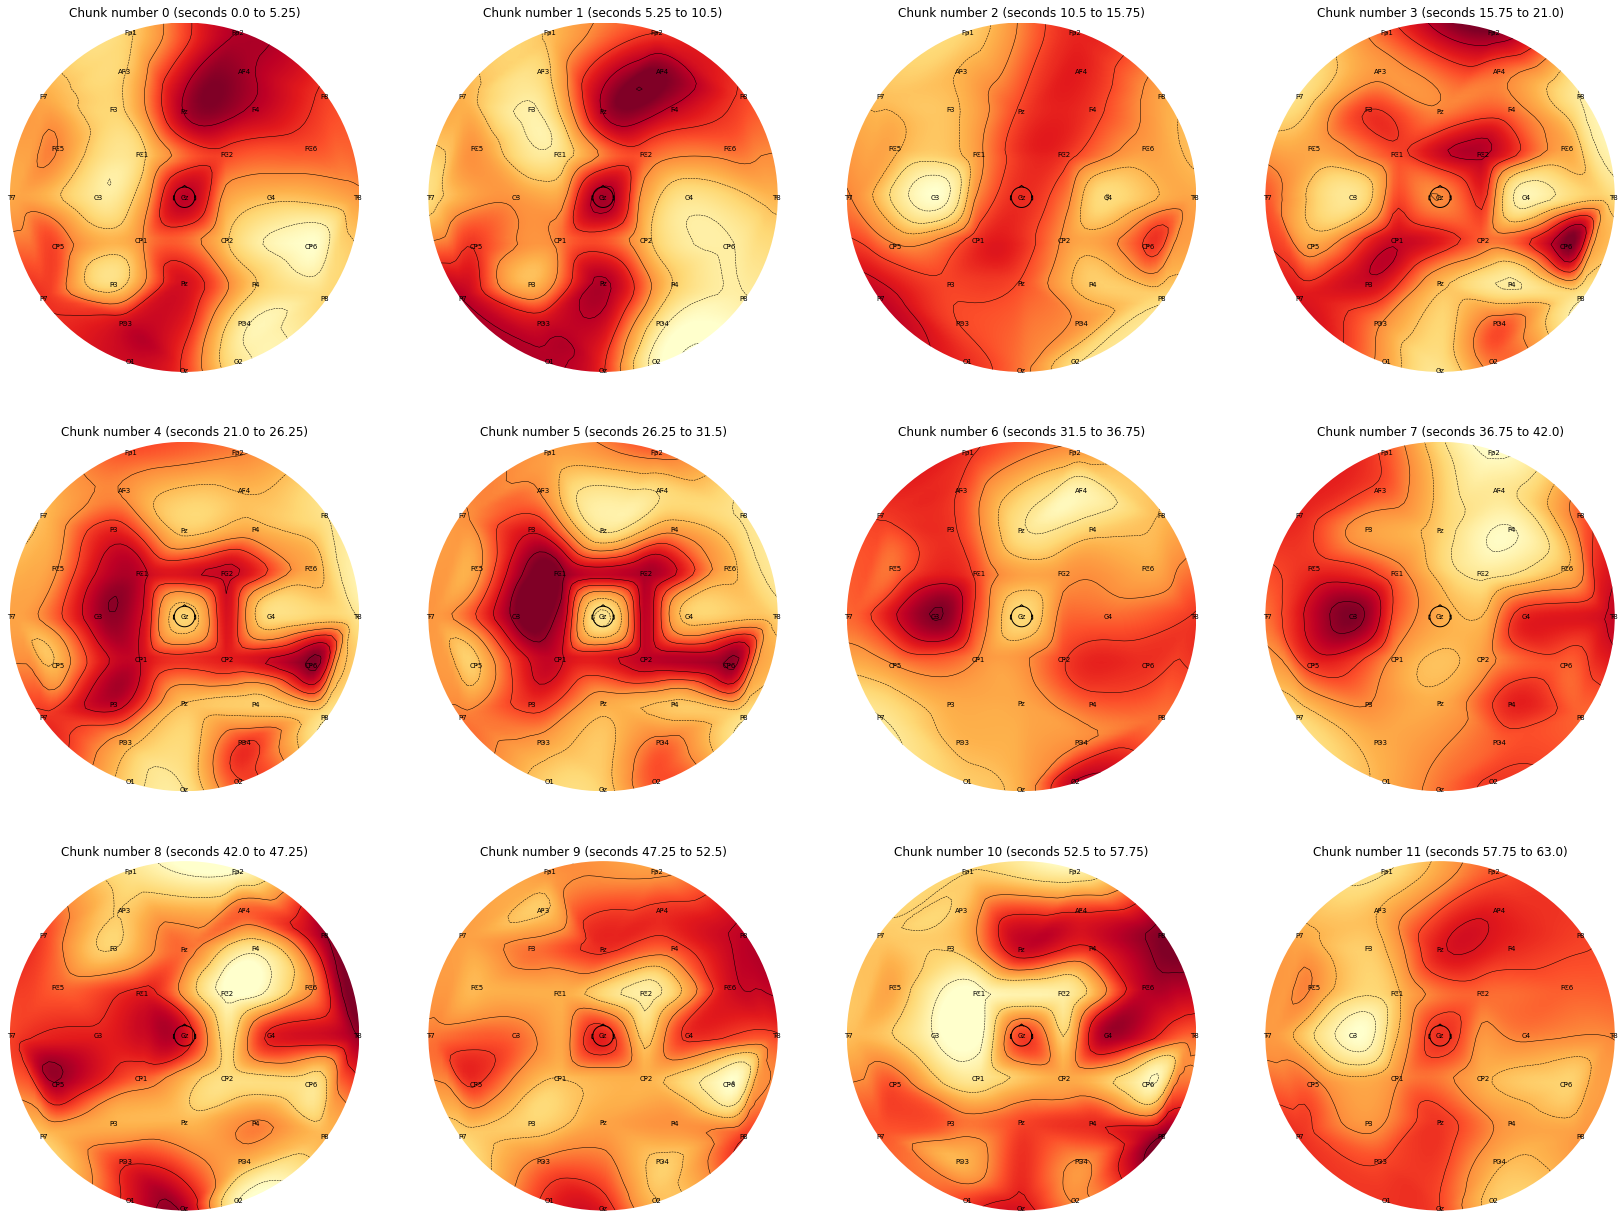

In [10]:
# Show all chunks and label (12)
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(30,20), gridspec_kw = {'wspace':0, 'hspace':0.2})
for i,chunk in enumerate(chunks):
    index = np.unravel_index(i, (3,4))
    ax = axes[index[0]][index[1]]
    ax.title.set_text(f'Chunk number {i} (seconds {5.25*i} to {5.25*(i+1)})')
    im,_ = mne.viz.topomap.plot_topomap(chunk,electrodes.positions_2d,names=electrodes.channel_names,show_names=True,axes=ax,cmap='YlOrRd',show=False)